In [1]:
!pip install deepchem rdkit torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 47.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv, GATConv, EdgeConv, global_mean_pool, SAGPooling, GraphNorm
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time

In [5]:
data = pd.read_csv('/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv') 
smiles_list = data['SMILES']
properties = data['G']

In [6]:
def smiles_to_graph(smiles, property_value):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    features = featurizer.featurize([smiles])
    if not features:
        return None

    atom_features = features[0].node_features
    edge_index = torch.tensor(features[0].edge_index, dtype=torch.long)
    edge_features = features[0].edge_features

    x = torch.tensor(atom_features, dtype=torch.float)
    y = torch.tensor([property_value], dtype=torch.float)
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

data_list = [smiles_to_graph(smiles, prop) for smiles, prop in zip(smiles_list, properties)]
data_list = [d for d in data_list if d is not None]  

<ipython-input-6-431ab471bb50>:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not features:


In [7]:
class GNN(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dims=[128, 64], 
                 aggr='mean', attn_heads=4, use_attention=True, mlp_layers=[64, 128, 64, 1]):
        """
        Parameters:
        - node_feat_dim: int, Number of node features.
        - edge_feat_dim: int, Number of edge features.
        - hidden_dims: list, Hidden dimensions for each NNConv layer.
        - aggr: str, Aggregation type ('mean', 'sum', 'max').
        - attn_heads: int, Number of attention heads for GAT.
        - use_attention: bool, Whether to apply attention at the end of each layer.
        - mlp_layers: list, Fully connected MLP layers after pooling.
        """
        super(GNN, self).__init__()
        self.num_layers = len(hidden_dims)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        self.edge_nns = torch.nn.ModuleList()
        self.attn_layers = torch.nn.ModuleList()
        
        prev_dim = node_feat_dim
        for i, h_dim in enumerate(hidden_dims):
            # Define the edge network to transform edge features
            edge_nn = Sequential(
                Linear(edge_feat_dim, h_dim),
                ReLU(),
                Linear(h_dim, prev_dim * h_dim)  # output dimensionality will be prev_dim * h_dim
            )
            self.edge_nns.append(edge_nn)
            
            # Define the NNConv layer, passing the edge_nn as the transformation function
            edge_conv = NNConv(in_channels=prev_dim, out_channels=h_dim, 
                               nn=edge_nn, aggr=aggr)
            self.convs.append(edge_conv)
            
            # GraphNorm for normalizing the node features
            self.norms.append(GraphNorm(h_dim))
            
            # Add attention layers if required
            if use_attention:
                self.attn_layers.append(GATConv(h_dim, h_dim // attn_heads, heads=attn_heads, concat=True))
          
            prev_dim = h_dim
        
        # Define the MLP layers after pooling
        mlp_layers_seq = []
        for i in range(len(mlp_layers) - 1):
            mlp_layers_seq.append(Linear(mlp_layers[i], mlp_layers[i + 1]))
            if i < len(mlp_layers) - 2:
                mlp_layers_seq.append(ReLU())
        
        self.mlp = Sequential(*mlp_layers_seq)
    
    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x, edge_index, edge_attr, batch = data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device), data.batch.to(device)
        
        for i, (conv, norm) in enumerate(zip(self.convs, self.norms)):
            x = conv(x, edge_index, edge_attr).relu()  
            x = norm(x)  
            if len(self.attn_layers) > i:
                x = self.attn_layers[i](x, edge_index).relu() 

        x = global_mean_pool(x, batch)
        
        return self.mlp(x)

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs, max_allowed_increases=5):
    consecutive_increase_counter = 0
    prev_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch).squeeze(-1)
            loss = criterion(outputs, batch.y.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch).squeeze(-1)
                loss = criterion(outputs, batch.y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0

        prev_val_loss = avg_val_loss

        if consecutive_increase_counter >= max_allowed_increases:
            print(f"Early stopping triggered after {max_allowed_increases} consecutive increases in validation loss!")
            break

    return train_losses, val_losses

In [9]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values = []
    predicted_values = []

    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            properties = batch.y
            outputs = model(batch).squeeze(-1)
            actual_values.extend(properties.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())
    end_time = time.time()

    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)
    
    print(f"Inference time per 1000 samples: {inference_time*1000:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot(
        [min(actual_values), max(actual_values)],
        [min(actual_values), max(actual_values)],
        color="red",
        linestyle="--",
        label="Ideal Fit"
    )
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
def run_pipeline(model, data_list, epochs, train_size, batch_size=32):
    train_data, test_data = train_test_split(data_list, test_size=(1 - train_size), random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    train_losses, val_losses = train_model(
        model, train_loader, val_loader, optimizer, criterion, device, epochs
    )

    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    evaluate_model(model, test_loader, device)

In [11]:
hidden_dims_opts = [
    [128, 64], [256, 128, 64], [512, 256, 128, 64]
]
attn_heads_opts = [1, 2, 4]
use_attention_opts = [False, True]

hidden_dims_opts_kernel_1 = hidden_dims_opts[:2]  
attn_heads_opts_kernel_1 = attn_heads_opts[2:]  

Training model with hidden_dims=[128, 64], attn_heads=4, use_attention=True
Epoch [1/100], Train Loss: 3067.8098, Validation Loss: 670.1446
Epoch [2/100], Train Loss: 550.9397, Validation Loss: 592.2275
Epoch [3/100], Train Loss: 463.8538, Validation Loss: 433.8042
Epoch [4/100], Train Loss: 393.5842, Validation Loss: 366.7283
Epoch [5/100], Train Loss: 343.8333, Validation Loss: 506.9663
Epoch [6/100], Train Loss: 303.3971, Validation Loss: 260.8880
Epoch [7/100], Train Loss: 270.5115, Validation Loss: 244.4849
Epoch [8/100], Train Loss: 239.9512, Validation Loss: 215.2026
Epoch [9/100], Train Loss: 217.9715, Validation Loss: 205.6154
Epoch [10/100], Train Loss: 198.6854, Validation Loss: 288.2286
Epoch [11/100], Train Loss: 181.3389, Validation Loss: 207.4302
Epoch [12/100], Train Loss: 167.1250, Validation Loss: 157.3935
Epoch [13/100], Train Loss: 153.6523, Validation Loss: 153.1541
Epoch [14/100], Train Loss: 147.7085, Validation Loss: 148.2958
Epoch [15/100], Train Loss: 139.9094

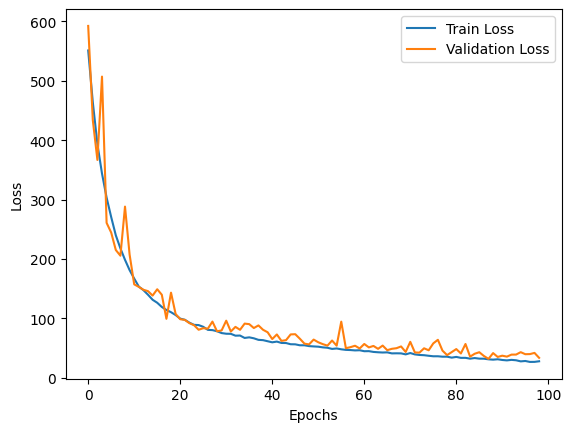

Inference time per 1000 samples: 6.4824
Mean Squared Error (MSE): 27.6129
Mean Absolute Error (MAE): 3.0149
R-Squared (R²): 0.9824


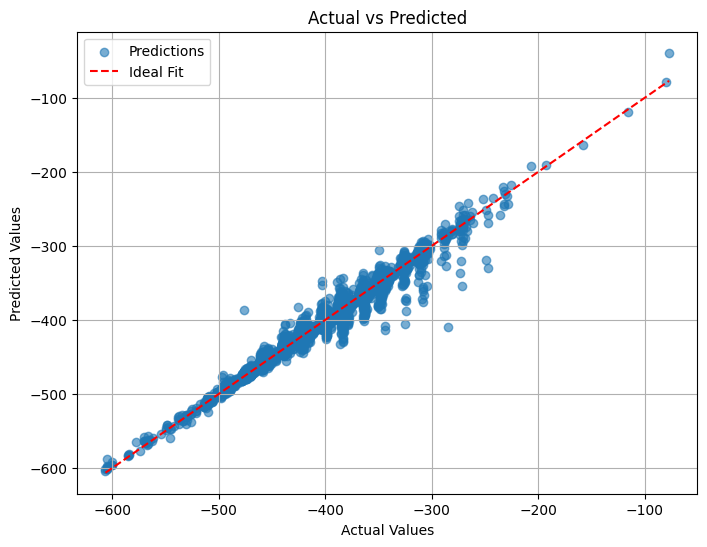

Training model with hidden_dims=[256, 128, 64], attn_heads=4, use_attention=True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch [1/100], Train Loss: 2986.4656, Validation Loss: 721.8113
Epoch [2/100], Train Loss: 566.0206, Validation Loss: 447.6441
Epoch [3/100], Train Loss: 440.3007, Validation Loss: 385.7369
Epoch [4/100], Train Loss: 343.2748, Validation Loss: 365.1282
Epoch [5/100], Train Loss: 280.9785, Validation Loss: 268.3281
Epoch [6/100], Train Loss: 244.1967, Validation Loss: 275.0561
Epoch [7/100], Train Loss: 206.6208, Validation Loss: 184.1916
Epoch [8/100], Train Loss: 181.0749, Validation Loss: 268.3490
Epoch [9/100], Train Loss: 160.2095, Validation Loss: 127.9272
Epoch [10/100], Train Loss: 144.6838, Validation Loss: 131.6217
Epoch [11/100], Train Loss: 125.7151, Validation Loss: 146.9219
Epoch [12/100], Train Loss: 121.4739, Validation Loss: 130.9706
Epoch [13/100], Train Loss: 105.3376, Validation Loss: 127.2395
Epoch [14/100], Train Loss: 100.2426, Validation Loss: 86.9602
Epoch [15/100], Train Loss: 99.0509, Validation Loss: 173.0675
Epoch [16/100], Train Loss: 88.9051, Validation Lo

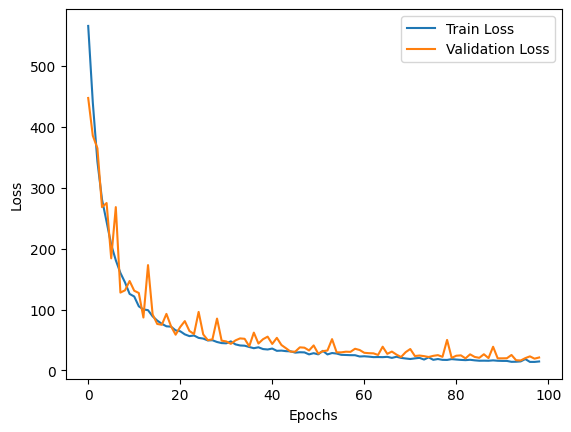

Inference time per 1000 samples: 9.7189
Mean Squared Error (MSE): 14.0975
Mean Absolute Error (MAE): 2.0761
R-Squared (R²): 0.9910


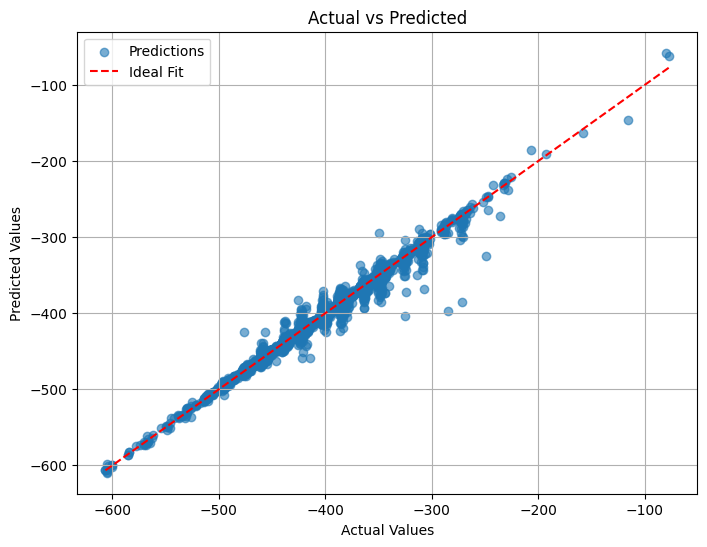

In [13]:
for use_attention in use_attention_opts:
    if use_attention:
        for hidden_dims in hidden_dims_opts_kernel_1:
            for attn_heads in attn_heads_opts_kernel_1:
                print(f"Training model with hidden_dims={hidden_dims}, attn_heads={attn_heads}, use_attention={use_attention}")

                model = GNN(node_feat_dim=30, edge_feat_dim=11, hidden_dims=hidden_dims, attn_heads=attn_heads, use_attention=use_attention)

                run_pipeline(model, data_list, epochs=100, train_size=0.75)